In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [3]:
# ==========================================================================
# Step 2. Data collection
# ==========================================================================
# Read the data description, see what information is available

# Task 2. import the datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

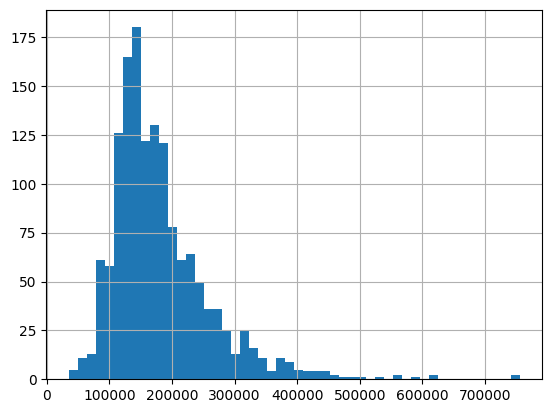

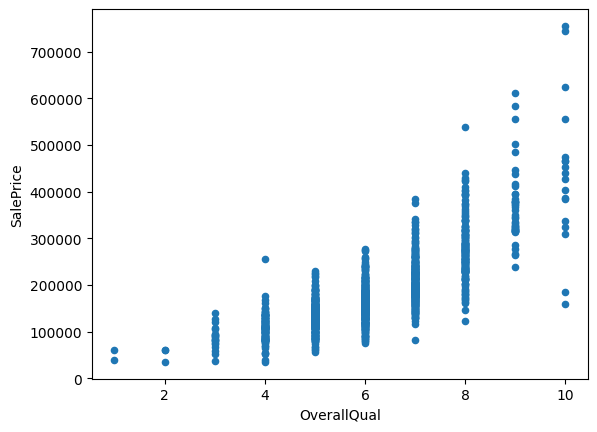

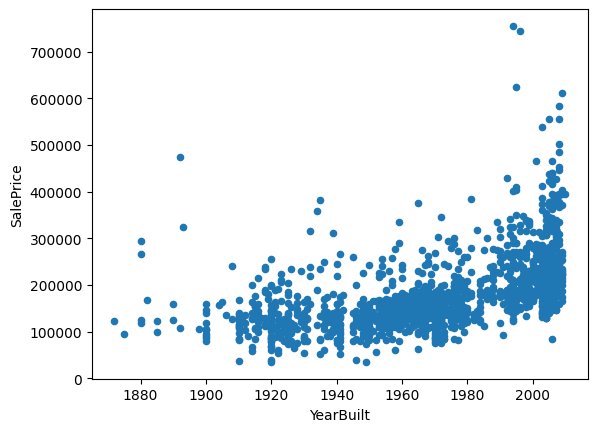

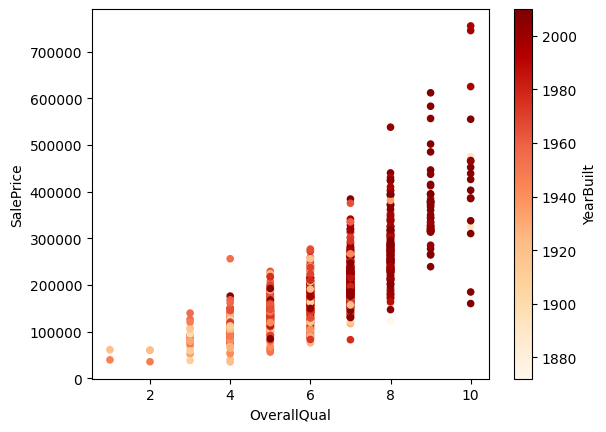

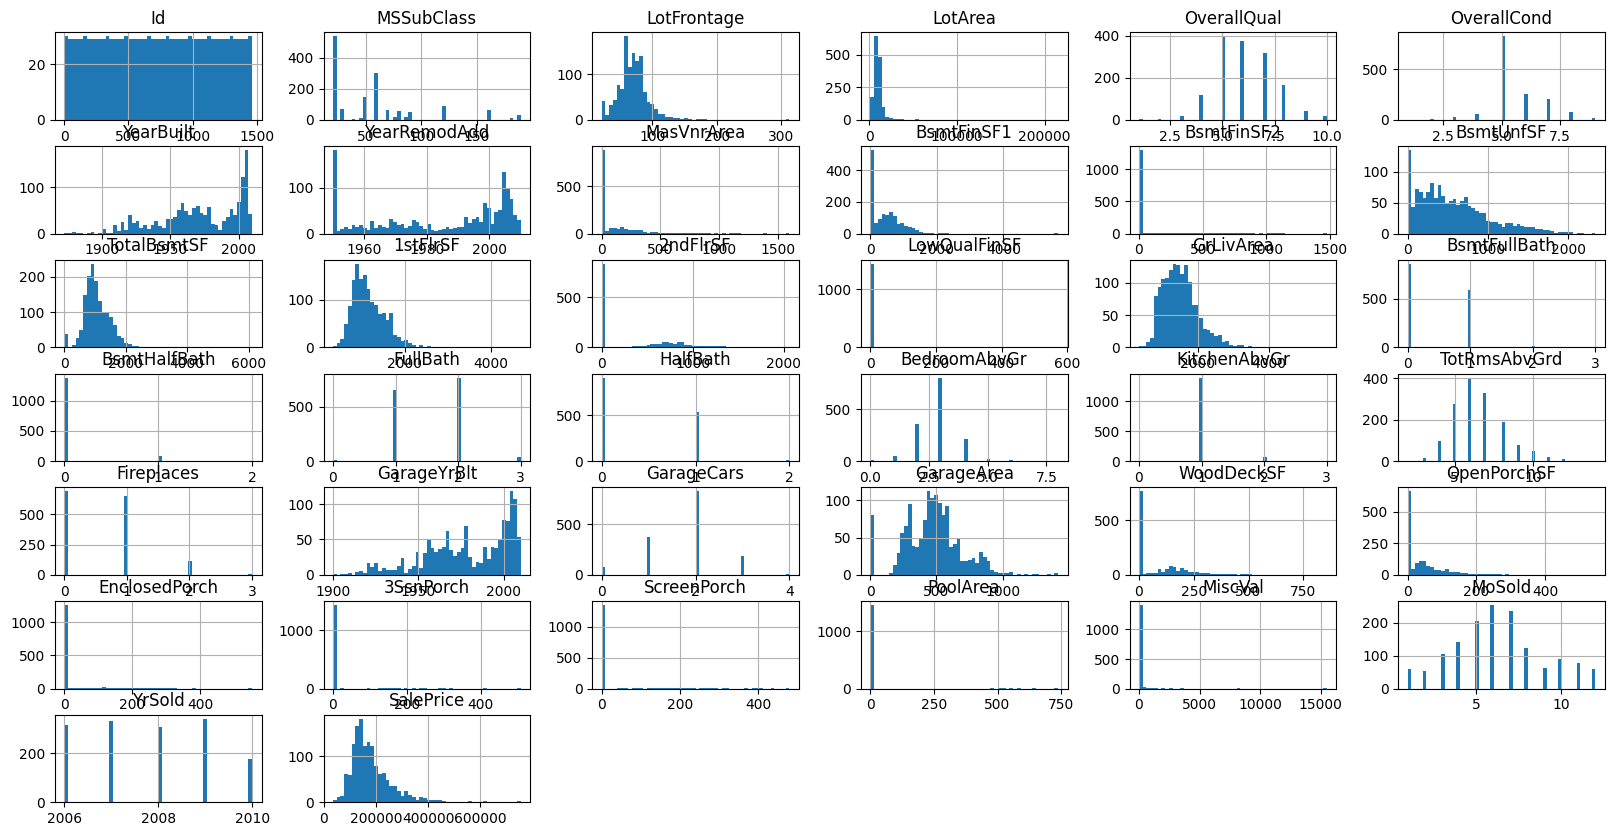

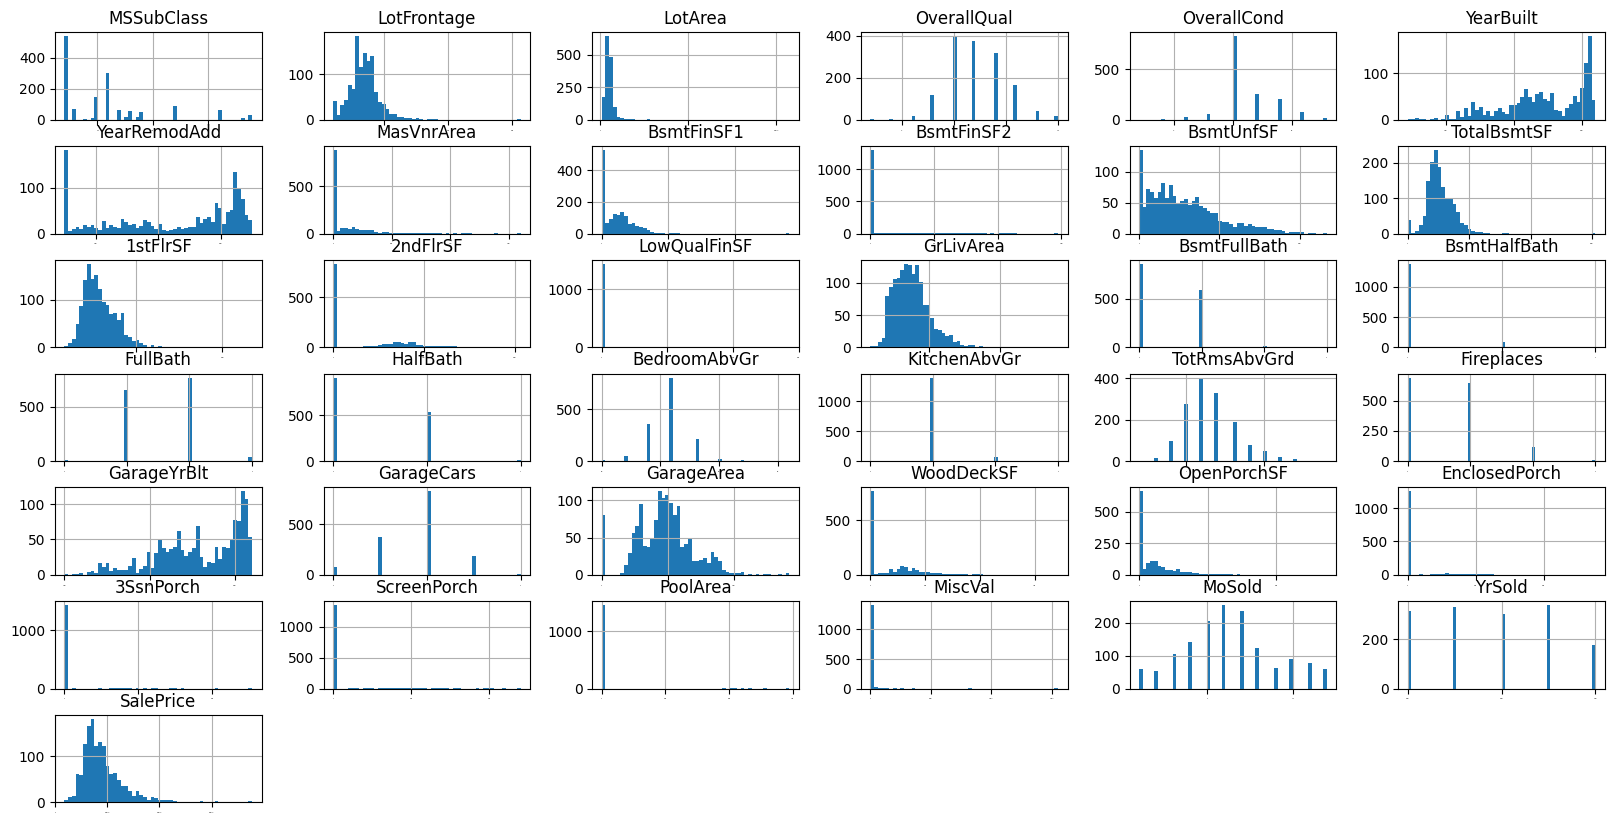

<Axes: >

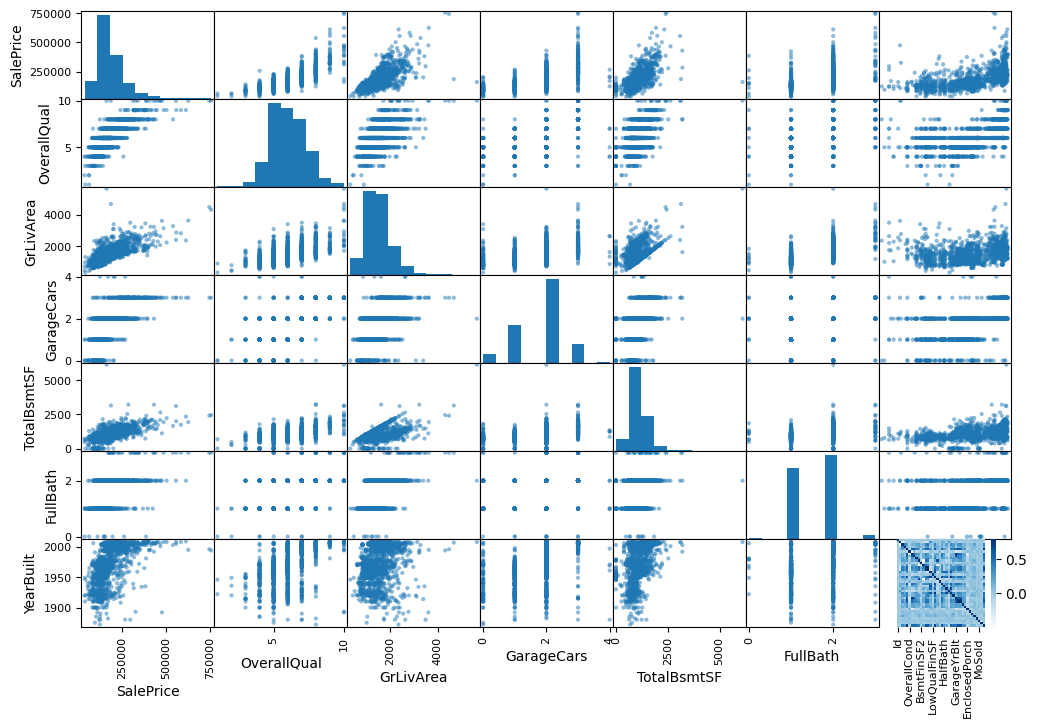

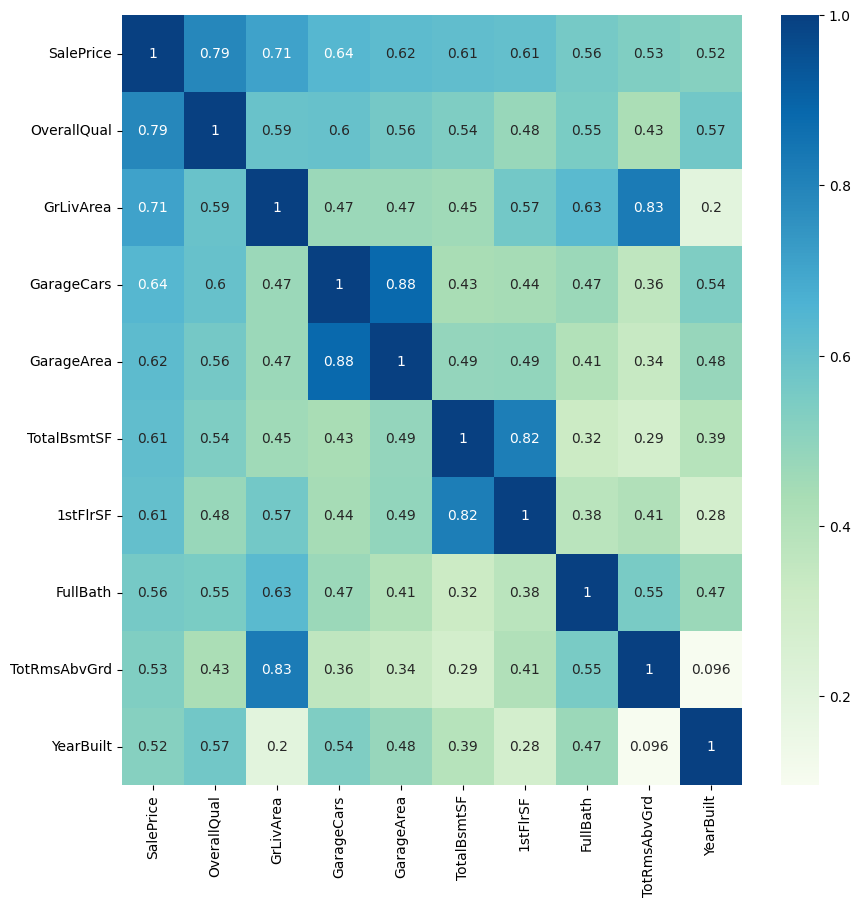

In [4]:
# ==========================================================================
# Step 3. Exploratory Data Analysis, Getting familiar with your data
# ==========================================================================

# Task 3.1. get descriptive statistics of your dataset
desc_stat = train.describe()

#  3.2. to 3.5. are econometrics type EDA
# Task 3.2. visualize the distribution of your label "SalePrice"
train["SalePrice"].hist(bins=50)
plt.show()  # looks it is skewed, need to fix this later

# check for several correlations
# Task 3.3 visualize the association between overall quality and sale price
train.plot.scatter(x='OverallQual', y='SalePrice')
plt.show()

# Task 3.4. visualize the association between YearBuilt and SalePrice
train.plot.scatter(x='YearBuilt', y='SalePrice')
plt.show()

# Task 3.5. visualize the association between three variables:
# (1) overall quality
# (2) SalePrice
# (3) YearBuilt
# hint: use OverallQual as X, SalePrice as y, and YearBuilt as color scale
train.plot.scatter(x='OverallQual', y='SalePrice', c='YearBuilt',
                   colormap='OrRd')
plt.show()


# Tasks 3.6 - 3.9 are more machine learning types EDA
# Task 3.6. Display all distributions of numerical variables
train.hist(bins=50, figsize=(20, 10))
plt.show()
train.iloc[:, 1:].hist(bins=50, figsize=(20, 10), xlabelsize=1)
plt.show()
# make a notes on skewed variables (if you want to know what happened).

# Task 3.7.visualize the associations of a set of variables of interest
interest_vars = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
                 'TotalBsmtSF', 'FullBath', 'YearBuilt']

scatter_matrix(train[interest_vars], figsize=(12, 8))

# Task 3.8. check how each variable is correlated with SalePrice
numeric_data = train.select_dtypes(include=[np.number])
corr_price = numeric_data.corr()["SalePrice"].sort_values(ascending=False)

# Task 3.9. Use a heatmap to visualize the correlation among variables.
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, vmax=0.8, square=True, cmap='Blues')

# this graph is not very informative, so let's try something more interesting
plt.figure(figsize=(10, 10))
sns.heatmap(train[corr_price.index[:10]].corr(), annot=True, cmap="GnBu")

In [5]:
# ==========================================================================
# step 4. Prepare the data (data pre-processing)
# =====================================================================

# Task 4.1. split the training data to train_set and test_set, with
# test_set take 20% of the data
train_set, test_set = train_test_split(train, test_size=0.2, random_state=42)
train_set.info()

# ALWAYS SPLIT BEFORE ANY DATA PRE-PROCESSING

# In Task 4.2 to 4.10, we will handling missing values
# Task 4.2. check how many missing values are there for each variable.
# use both total count and percentage together to report the result
count_missing_train = train_set.isnull().sum().sort_values(ascending=False)
percent_missing_train = (train_set.isnull().sum() / train_set.isnull().count()
                         * 100).sort_values(ascending=False)

missing_data_train = pd.concat([count_missing_train, percent_missing_train],
                               axis=1)

# a rule of thumb: drop columns if too many missing value and not important
# don't drop rows unless no other choice: since you can't drop any row in test!

# after some consideration, let's drop columns that have more than 10% missing

# Task 4.3. drop variables that have 10% or above missing variables.
drop_vars = percent_missing_train.index[percent_missing_train > 10].tolist()
train_set.drop(drop_vars, axis=1, inplace=True)

# Task 4.4. repeat 4.2 to check missing values again
count_missing_train = train_set.isnull().sum().sort_values(ascending=False)
percent_missing_train = (train_set.isnull().sum() / train_set.isnull().count()
                         * 100).sort_values(ascending=False)

missing_data_train = pd.concat([count_missing_train, percent_missing_train],
                               axis=1)

still_missing = percent_missing_train.index[percent_missing_train > 0].tolist()


# to fill missings, we need to first separate numerical and categorical values
# Task 4.5. split the train_set into two dataframes:
# # train_num that only include numerical variables
# # train_cat that only include non-numerical variables
train_set[still_missing].dtypes
train_num = train_set.select_dtypes(include=np.number)
train_cat = train_set.select_dtypes(exclude=np.number)

# among the still-missings, let's first fill in the numerical values

# Task 4.6. use mean replacement to impute missing values for "MasVnrArea"
imputer_median = SimpleImputer(strategy="median")
x = imputer_median.fit_transform(train_num[["MasVnrArea"]])
train_num["MasVnrArea"] = x


# Task 4.7. use knn algorithm to impute missing values for "GarageYrBlt"
# let's drop the variable id, as it does not provide any information
imputer_knn = KNNImputer(n_neighbors=2)
x = imputer_knn.fit_transform(train_num[["GarageYrBlt"]])
train_num["GarageYrBlt"] = x

# Task 4.8. use the most frequent value to fill all missing categorical vars
# other fancy algorithms (on your own, domain knowledge)
train_cat.fillna(train_cat.mode().iloc[0], inplace=True)

# Task 4.9 combine train_num and train_cat back together as train_set
train_set = pd.concat([train_num, train_cat], axis=1)

# Task 4.10. repeat Task 4.2 to check missing value again
count_missing_train = train_set.isnull().sum().sort_values(ascending=False)
percent_missing_train = (train_set.isnull().sum() / train_set.isnull().count()
                         * 100).sort_values(ascending=False)

missing_data_train = pd.concat([count_missing_train, percent_missing_train],
                               axis=1)

# No missing data! Horay!


<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    951 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          74 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallCond

In [6]:
# ==========================================================================
# step 5. select variables (feature engineering)
# =====================================================================
train_num = train_set.select_dtypes(include=np.number)
train_cat = train_set.select_dtypes(exclude=np.number)

# Task 5.1. Create two new features that might be useful for prediction
# Task 5.1.1. add Total Square feet = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
train_num['TotalSF'] = (train_num["TotalBsmtSF"] + train_num["1stFlrSF"]
                        + train_num["2ndFlrSF"])

# task 5.1.2 add bedroom to total room ratio as a new feature
train_num['Bed_ratio'] = train_num['BedroomAbvGr']/train_num['TotRmsAbvGrd']

# Task 5.2. in this task, we will deal with skewed numeric features
# Task 5.2.1 check for variable skewness
skewness = train_num.skew().sort_values(ascending=False)

# Task 5.2.2 get a list of highly skewed variables
skewed_vars = skewness.index[abs(skewness) >= 1].tolist()

# Task 5.2.3 Split the df train_num into two parts, based on if the features
# are highly skewed.
unskwews_num_data = train_num.drop(skewed_vars, axis=1)
skewed_num_data = train_num[skewed_vars]

# Task 5.2.4 use log-transform to adjust the highly skewed data
adjust_skewed = np.log1p(skewed_num_data)

# Task 5.2.5 merge the unskewed_num_data and skewed_num_data back to train_num
train_num = pd.concat([unskwews_num_data, adjust_skewed], axis=1)

# Task 5.3. In this task, we will deal with categorical variables
# Task 5.3.1. convert all "object" dtype to "category" dtype
train_cat = train_cat.astype("category")

# Task 5.3.2 check the data description file to see if any catagorical features
# has ordinal relationship.

# in particular, any categorical variables that have numerical meanings,
# we need to perform ordinal encoding for them
# the sklearn library has a ordicalEncoder class designed for this purpose,
# here, let's just do it mannually.
# check codebook and we find:
# # ExterQual     (Ex, Gd, Ta, Fa, Po),
# # ExterCond     (Ex, Gd, Ta, Fa, Po),
# # HeatingQC     (Ex, Gd, Ta, Fa, Po),
# # KitchenQual   (Ex, Gd, Ta, Fa, Po),
# # BsmtQual      (Ex, Gd, Ta, Fa, Po, NA)
# # BsmtCond      (Ex, Gd, Ta, Fa, Po, NA)
# # GarageQual    (Ex, Gd, Ta, Fa, Po, NA)
# # GarageCond    (Ex, Gd, Ta, Fa, Po, NA)
# # BsmtExposure  (Gd, Av, Mn, No, NA)
# # BsmtFinType1  (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
# # BsmtFinType2  (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
# # Functional: (Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal)
# # GarageFinish: (Fin, RFn, Unf, NA)

# Task 5.3.3. encoding categorical features with ordinal relationship
# Encoding rules:
# for ExterQual, ExterCond, HeatingQC BsmtQual, BsmtCond,
# KitchenQual, GarageQual, GarageCond
# NA = 0, Po = 1, Fa = 2, TA = 3, Gd = 4, Ex = 5

cat_to_num = ["ExterQual", "ExterCond", "HeatingQC", "BsmtQual", "BsmtCond",
              "KitchenQual", "GarageQual", "GarageCond"]
train_cat[cat_to_num] = train_cat[cat_to_num].replace(
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4, 5])

# Encoding rules for BsmtExposure:
# NA = 0, No = 1, Mn = 2, Av = 3, Gd = 4

train_cat["BsmtExposure"] = train_cat["BsmtExposure"].replace(
    ["NA", "No", "Mn", "Av", "Gd"], [0, 1, 2, 3, 4])

# Encoding rules for BsmtFinType1 and BsmtFinType2:
# GLQ = 6, ALQ = 5, BLQ = 4, Rec = 3, LwQ = 2, Unf = 1, NA = 0
bsmtTypes = ["BsmtFinType1", "BsmtFinType2"]
train_cat[bsmtTypes] = train_cat[bsmtTypes].replace(
    ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    [6, 5, 4, 3, 2, 1, 0])

# Encoding rules for Functional:
# Typ=7, Min1=6, Min2=5, Mod=4, Maj1=3, Maj2=2, Sev=1, Sal=0
train_cat["Functional"] = train_cat["Functional"].replace(
    ["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
    [7, 6, 5, 4, 3, 2, 1, 0])

# Encoding rules for GarageFinish
# Fin=3, RFn=2, Unf=1, NA=0
train_cat["GarageFinish"] = train_cat["GarageFinish"].replace(
    ["Fin", "RFn", "Unf", "NA"],
    [3, 2, 1, 0])

# Task 5.3.3.combine the above features toghether,
# put them in a df, name it as "num_from_cat"
num_from_cat = train_cat[cat_to_num + bsmtTypes + ["BsmtExposure", "Functional",
                                         "GarageFinish"]]

# Task 5.3.4. double check if all features in num_from_cat are numeric
num_from_cat.info()
num_from_cat = num_from_cat.astype(int)
# all good, cool!

# Next, we will deal with all the rest categorical features that doesn't have
# ordinal relationships

# Task 5.3.5. drop the num_from_cat part from train_cat, so that
# the df #train_cat only contain categorial variables
train_cat = train_cat.drop(num_from_cat, axis=1)

# Taks 5.3.6. Use OneHotEncoder in sklearn to convert them into dummies,
# ignore unknwon values when transform
ohe = OneHotEncoder(handle_unknown='ignore')
# encoding
dum_from_cat = pd.DataFrame(ohe.fit_transform(train_cat).toarray())

# reforming the dataframe
col_names = list(ohe.get_feature_names_out())
dum_from_cat.columns = col_names
dum_from_cat.index = train_cat.index

#  Task 5.3.7. combine num_from_cat and dum_from_cat back to train_cat_to_num
train_cat_to_num = pd.concat([num_from_cat, dum_from_cat], axis=1)

# Task 5.4 lastly, combine train_num and train_cat_to_num back,
# name the new train set as "train_set_allnum"
train_set_allnum = pd.concat([train_num, train_cat_to_num], axis=1)

# Task 5.5. double check if all variables are numeric
still_cat = train_set_allnum.select_dtypes(exclude=np.number)

# all good!


<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ExterQual     1168 non-null   category
 1   ExterCond     1168 non-null   category
 2   HeatingQC     1168 non-null   category
 3   BsmtQual      1168 non-null   category
 4   BsmtCond      1168 non-null   category
 5   KitchenQual   1168 non-null   category
 6   GarageQual    1168 non-null   category
 7   GarageCond    1168 non-null   category
 8   BsmtFinType1  1168 non-null   category
 9   BsmtFinType2  1168 non-null   category
 10  BsmtExposure  1168 non-null   category
 11  Functional    1168 non-null   category
 12  GarageFinish  1168 non-null   category
dtypes: category(13)
memory usage: 26.7 KB


C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\531273510.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_cat[cat_to_num] = train_cat[cat_to_num].replace(
C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\531273510.py:67: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_cat[cat_to_num] = train_cat[cat_to_num].replace(
C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\531273510.py:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call

In [8]:
# ============================================================================
# Step 6. replicate EVERYTHING we have done to the train set on the test set
# ============================================================================

# Task 6.1. check how many missing values are there for each variable.
# use both total count and percentage together to report the result
# let's drop columns that have more than 10% missing
count_missing_test = test_set.isnull().sum().sort_values(ascending=False)
percent_missing_test = (test_set.isnull().sum() / test_set.isnull().count()
                        * 100).sort_values(ascending=False)

# Task 6.2. drop variables that have 10% or above missing variables.
missing_data_test = pd.concat([count_missing_test, percent_missing_test],
                              axis=1)

drop_list = percent_missing_test.index[percent_missing_test > 10].tolist()
test_set.drop(drop_list, axis=1, inplace=True)

# Task 6.3. repeat 6.1 to check missing values again
count_missing_test = test_set.isnull().sum().sort_values(ascending=False)
percent_missing_test = (test_set.isnull().sum() / test_set.isnull().count()
                        * 100).sort_values(ascending=False)

missing_data_test = pd.concat([count_missing_test, percent_missing_test],
                              axis=1)

still_missing = percent_missing_test.index[percent_missing_test > 0].tolist()

# to fill missings, we need to first separate numerical and categorical values

# Task 6.4. split the test_set into two dataframes:
# # test_num that only include numerical variables
# # test_cat that only include non-numerical variables
test_set[still_missing].dtypes
test_num = test_set.select_dtypes(include=np.number)
test_cat = test_set.select_dtypes(exclude=np.number)

# among the still-missings, let's first fill in the numerical values
# Task 6.5. use mean replacement to impute missing values for "MasVnrArea"
imputer_median = SimpleImputer(strategy="median")
x = imputer_median.fit_transform(test_num[["MasVnrArea"]])
test_num["MasVnrArea"] = x


# Task 6.6. use knn algorithm to impute missing values for "GarageYrBlt"
# let's drop the variable id, as it does not provide any information
imputer_knn = KNNImputer(n_neighbors=2)
x = imputer_knn.fit_transform(test_num[["GarageYrBlt"]])
test_num["GarageYrBlt"] = x

# Task 6.7. use the most frequent value to fill all missing categorical vars
# other fancy algorithms (on your own, domain knowledge)
test_cat.fillna(test_cat.mode().iloc[0], inplace=True)

# Task 6.8 combine test_num and test_cat back together as test_set
test_set = pd.concat([test_num, test_cat], axis=1)

# Task 6.9. repeat Task 6.1 to check missing value again
count_missing_test = test_set.isnull().sum().sort_values(ascending=False)
percent_missing_test = (test_set.isnull().sum() / test_set.isnull().count()
                        * 100).sort_values(ascending=False)

missing_data_test = pd.concat([count_missing_test, percent_missing_test],
                              axis=1)

# Task 6.10. Create two new features that might be useful for prediction
# Task 6.10.1. add Total Square feet = TotalBsmtSF + 1stFlrSF + 2ndFlrSF 
test_num['TotalSF'] = (test_num["TotalBsmtSF"] + test_num["1stFlrSF"]
                       + test_num["2ndFlrSF"])

# task 6.10.2 add bedroom to total room ratio as a new feature
test_num['Bed_ratio'] = test_num['BedroomAbvGr']/test_num['TotRmsAbvGrd']

# Task 6.11.. in this task, we will deal with skewed numeric features
# Task 6.11.1 check for variable skewness 
skewness = test_num.skew().sort_values(ascending=False)

# Task 6.11.2 get a list of highly skewed variables
skewed_vars = skewness.index[abs(skewness) >= 1].tolist()

# Task 6.11.3 Split the df test_num into two parts, based on if the features 
# are highly skewed.
unskews_num_data = test_num.drop(skewed_vars, axis=1)
skewed_num_data = test_num[skewed_vars]

# Task 6.11.4 use log-transform to adjust the highly skewed data
adjust_skewed = np.log1p(skewed_num_data)

# Task 6.11.5 merge the unskewed_num_data and skewed_num_data back to test_num
test_num = pd.concat([unskews_num_data, adjust_skewed], axis=1)


# Task 6.12. In this task, we will deal with categorical variables
# Task 6.12.1. convert all "object" dtype to "category" dtype
test_cat = test_cat.astype("category")

# Task 6.12.2 check the data description file to see if any catagorical features
# has ordinal relationship.

# in particular, any categorical variables that have numerical meanings,
# we need to perform ordinal encoding for them
# the sklearn library has a ordicalEncoder class designed for this purpose,
# here, let's just do it mannually.


# check codebook and we find:
# # ExterQual     (Ex, Gd, Ta, Fa, Po),
# # ExterCond     (Ex, Gd, Ta, Fa, Po),
# # HeatingQC     (Ex, Gd, Ta, Fa, Po),
# # KitchenQual   (Ex, Gd, Ta, Fa, Po),
# # BsmtQual      (Ex, Gd, Ta, Fa, Po, NA)
# # BsmtCond      (Ex, Gd, Ta, Fa, Po, NA)
# # GarageQual    (Ex, Gd, Ta, Fa, Po, NA)
# # GarageCond    (Ex, Gd, Ta, Fa, Po, NA)
# # BsmtExposure  (Gd, Av, Mn, No, NA)
# # BsmtFinType1  (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
# # BsmtFinType2  (GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA)
# # Functional: (Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal)
# # GarageFinish: (Fin, RFn, Unf, NA)

# Task 6.12.3. encoding categorical features with ordinal relationship
# Encoding rules:
# for ExterQual, ExterCond, HeatingQC BsmtQual, BsmtCond,
# KitchenQual, GarageQual, GarageCond
# NA = 0, Po = 1, Fa = 2, TA = 3, Gd = 4, Ex = 5
cat_to_num = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual",
              "BsmtQual", "BsmtCond", "GarageQual", "GarageCond"]
test_cat[cat_to_num] = test_cat[cat_to_num].replace(
    ["NA", "Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4, 5])

# Encoding rules for BsmtExposure:
# NA = 0, No = 1, Mn = 2, Av = 3, Gd = 4
test_cat["BsmtExposure"] = test_cat["BsmtExposure"].replace(
    ["NA", "No", "Mn", "Av", "Gd"], [0, 1, 2, 3, 4])


# Encoding rules for BsmtFinType1 and BsmtFinType2:
# GLQ = 6, ALQ = 5, BLQ = 4, Rec = 3, LwQ = 2, Unf = 1, NA = 0
bsmtTypes = ["BsmtFinType1", "BsmtFinType2"]
test_cat[bsmtTypes] = test_cat[bsmtTypes].replace(
    ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"],
    [6, 5, 4, 3, 2, 1, 0])

# Encoding rules for Functional:
# Typ=7, Min1=6, Min2=5, Mod=4, Maj1=3, Maj2=2, Sev=1, Sal=0
test_cat["Functional"] = test_cat["Functional"].replace(
	["Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"],
	[7, 6, 5, 4, 3, 2, 1, 0])

# Encoding rules for GarageFinish
# Fin=3, RFn=2, Unf=1, NA=0
test_cat["GarageFinish"] = test_cat["GarageFinish"].replace(
	["Fin", "RFn", "Unf", "NA"],
	[3, 2, 1, 0])

# Task 6.12.3.combine the above features toghether,
# put them in a df, name it as "num_from_cat"
num_from_cat = test_cat[cat_to_num + bsmtTypes + ["BsmtExposure", "Functional", "GarageFinish"]]

# Task 6.12.4. double check if all features in num_from_cat are numeric
num_from_cat.info()
num_from_cat = num_from_cat.astype(int)

# Next, we will deal with all the rest categorical features that doesn't have
# ordinal relationships

# Task 6.12.5. drop the num_from_cat part from test_cat, so that 
# the df #test_cat only contain categorial variables 
test_cat = test_cat.drop(num_from_cat, axis=1)

# Taks 6.12.6. Use OneHotEncoder in sklearn to convert them into dummies,
# ignore unknwon values when transform

# encoding. here, do not create new object for OneHotEncoder, instead,
# you should use oht.transform() to do the job.
dum_from_cat = pd.DataFrame(ohe.transform(test_cat).toarray())

# reforming the dataframe
col_names = list(ohe.get_feature_names_out())
dum_from_cat.columns = col_names
dum_from_cat.index = test_cat.index

#  Task 6.12.7. combine num_from_cat and dum_from_cat back to test_cat_to_num
test_cat_to_num = pd.concat([num_from_cat, dum_from_cat], axis=1)

# Task 5.4 lastly, combine test_num and test_cat_to_num back,
# name the new test set as "test_set_allnum"
test_set_allnum = pd.concat([test_num, test_cat_to_num], axis=1)

# Task 6.14 double check if all variables are numeric
still_cat = test_set_allnum.select_dtypes(exclude=np.number)

# Task 6.15. check if train set and test set have the same number of features
if train_set_allnum.shape[1] == test_set_allnum.shape[1]:
    print("The train set and test set have the same number of features.")

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 892 to 722
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   ExterQual     292 non-null    category
 1   ExterCond     292 non-null    category
 2   HeatingQC     292 non-null    category
 3   KitchenQual   292 non-null    category
 4   BsmtQual      292 non-null    category
 5   BsmtCond      292 non-null    category
 6   GarageQual    292 non-null    category
 7   GarageCond    292 non-null    category
 8   BsmtFinType1  292 non-null    category
 9   BsmtFinType2  292 non-null    category
 10  BsmtExposure  292 non-null    category
 11  Functional    292 non-null    category
 12  GarageFinish  292 non-null    category
dtypes: category(13)
memory usage: 8.4 KB
The train set and test set have the same number of features.


C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\2597470498.py:128: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_cat[cat_to_num] = test_cat[cat_to_num].replace(
C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\2597470498.py:128: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  test_cat[cat_to_num] = test_cat[cat_to_num].replace(
C:\Users\nxj224\AppData\Local\Temp\ipykernel_36964\2597470498.py:128: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca